In this Python notebook we will try to use vision transformer as another method to implement our classification plants & diseases task.
This code is based on the ideas that presented on the paper - "An Image Is Worth 16x16 Words"

part 1 - useful imports and functions:

In [165]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import time
from torchvision import datasets, transforms
import random

def divide_to_patches(image, patch_size=16, grid_w=14, grid_h=14):
    image_width, image_height = image.shape[1], image.shape[2]
    num_of_patches = (image_width // patch_size) * (image_height // patch_size)
    patches_list = []
    patches = np.zeros((num_of_patches, 3, patch_size, patch_size))
    for i in range(grid_h):
        for j in range(grid_w):
            patches_list.append(image[0:3, i*patch_size : (i+1)*patch_size, j*patch_size : (j+1)*patch_size])
    for i in range(len(patches_list)):
        patches[i] = patches_list[i]
    return torch.Tensor(patches)

def flatten_patch_to_sequence(patch):
    flattened_tensor = patch.view(196, -1)
    return flattened_tensor

def show_image_patches(patches: torch.Tensor, grid_width=14, grid_height=14):
    num_images = patches.shape[0]
    fig, axes = plt.subplots(grid_width, grid_height, figsize=(10, 10))
    for i in range(num_images):
        part_of_image = patches[i].clamp(0, 1).numpy()
        ax = axes[i // grid_width, i % grid_height]
        ax.imshow(part_of_image.transpose(1, 2, 0)) 
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def show_sequenced_patch(patches: torch.Tensor, grid_width=14, grid_height=14):
    num_images = patches.shape[0]
    fig, axes = plt.subplots(1, grid_width * grid_height, figsize=(30, 1))
    for i in range(num_images):
        part_of_image = patches[i].clamp(0, 1).numpy()
        ax = axes[i]
        ax.imshow(part_of_image.transpose(1, 2, 0)) 
        ax.axis('off')
    plt.show()


part 2 - loading the dataset:

In [11]:
local_root_dir = 'Dataset/PlantVillage'

dataset_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

classes = ["Apple, Scab", "Apple, Black rot", "Apple, Cedar rust", "Apple, Healthy", "Blueberry, Healthy",
           "Cherry, Healthy", "Cherry, Powdery mildew", "Corn, Cercospora spot", "Corn, Common rust",
           "Corn, Healthy", "Corn Northern Leaf Blight", "Grape, Black rot", "Grape, Esca", "Grape, Healthy",
           "Grape, Leaf blight (Isariposis)", "Orange, Haunglongbing", "Peach, Bacterial spot",
           "Peach, Healthy", "Pepper, Bacterial spot", "Pepper, Healthy", "Potato, Early Blight",
           "Potato, Healthy", "Potato, Late Blight", "Raspberry, Healthy", "Soybean, Healthy",
           "Squash, Powdery mildew", "Strawberry, Healthy", "Strawberry, Leaf Scorch", "Tomato, Bacterial spot",
           "Tomato, Early Blight", "Tomato, Healthy", "Tomato, Late Blight", "Tomato, Leaf Mold",
           "Tomato, Septoria leaf spot", "Tomato, Spider mites", "Tomato, Target spot", "Tomato, Moasic virus",
           "Tomato, Yellow leaf curl virus"]

dataset = datasets.ImageFolder(root=local_root_dir + '/train',transform=dataset_transform)
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = int(0.1 * dataset_size)
valid_size = dataset_size - train_size - test_size
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])
print(f"train dataset has {train_size} samples\nvalidation dataset has {valid_size} samples\ntest dataset has {test_size} samples")


train dataset has 34755 samples
validation dataset has 4345 samples
test dataset has 4344 samples


part 3 - preparing the data for the encoder:

According to the paper it is required to split the input images to patches. We will use the same size as suggested - 16x16 patches.
The images are with size of (224,224), therefore each image will have $\frac{224}{16}$ $\cdot$ $\frac{224}{16}$ = $14$$\cdot$$14$ = $196$ patches.
After we patched the image, we need to make it looks more like a sequence, so we will flatten the tensor (image) to 196$\times$768 tensor, where 196 represents the number of patches and 768 represents the flattened tensor of each patch: $\underbrace{\text{16}}_{\Large\text(1)}$ $\times$ $\underbrace{\text{16}}_{\Large\text(2)}$ $\times$ $\underbrace{\text{3}}_{\Large\text(3)}$
$(1)  \text{Patch width}$
$(2)  \text{Patch height}$
$(3)  \text{Patch channels}$


choosing random picture from the train set...
shape of the image divided to patches: torch.Size([196, 3, 16, 16])


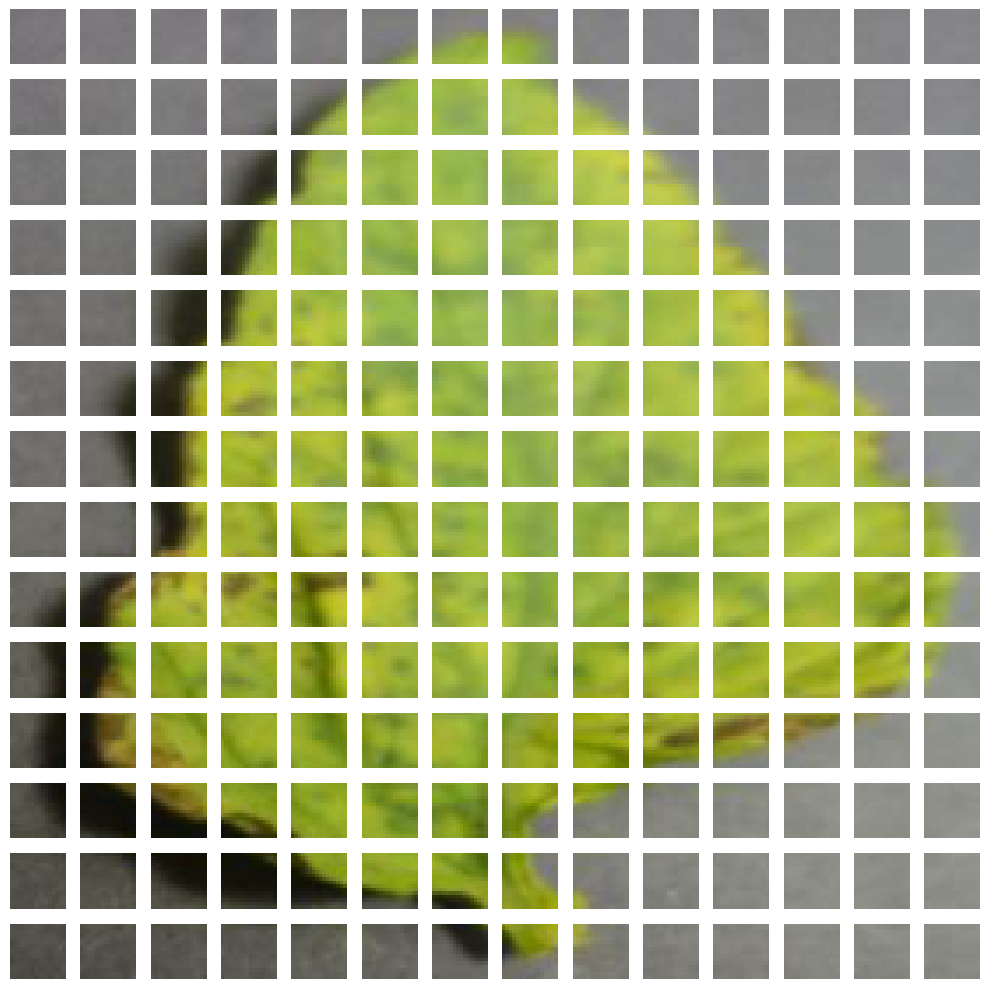

shape of the sequenced patch: torch.Size([196, 768])


In [166]:
print('choosing random picture from the train set...')
random_picture_idx = random.randint(0, len(train_set) - 1)
picture_position = 0
output_patched_image = divide_to_patches(train_set[random_picture_idx][picture_position])
print(f'shape of the image divided to patches: {output_patched_image.shape}')
show_image_patches(output_patched_image)
sequenced_patch = flatten_patch_to_sequence(output_patched_image)
print(f'shape of the sequenced patch: {sequenced_patch.shape}')
show_sequenced_patch(output_patched_image)

torch.Size([196, 768])
